In [1]:
import sys
print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on November 27 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [30]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### 'unit test'

In [7]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.07,-0.2,
                                 2.7,1.5,-0.2,0.00,
                                 0.1,-0.4,0.90,
                                 0.10,0.91,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

version of the code is: 0.14
-inf


In [8]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

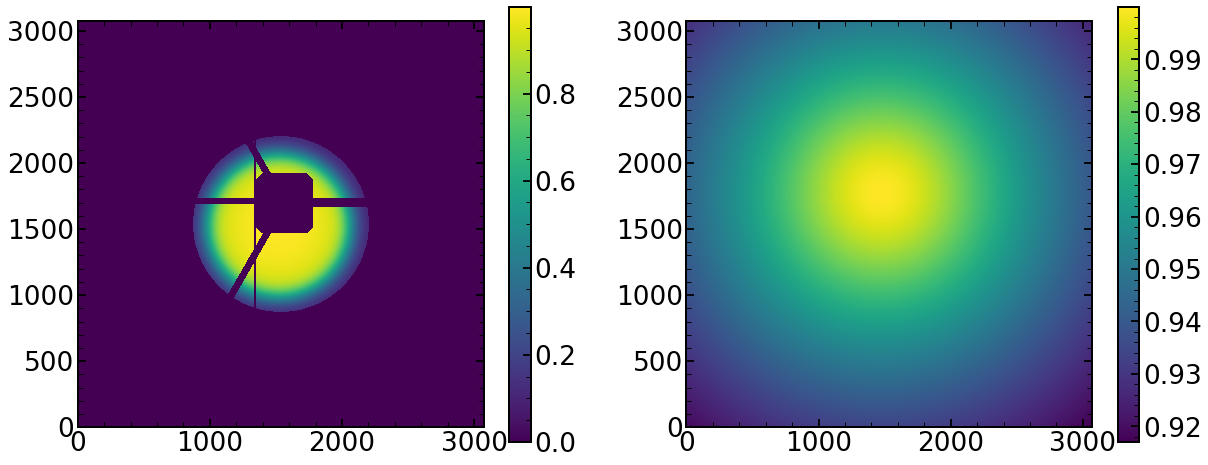

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(ilum,origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(radiometricEffectArray,origin='lower')
plt.colorbar()

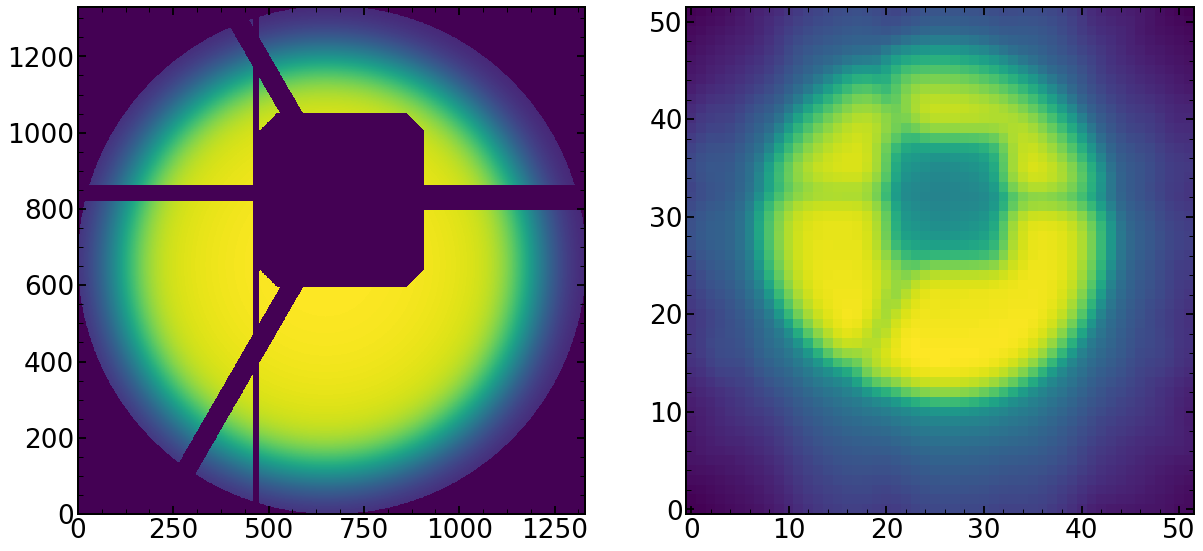

In [11]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

# Plan

1. Determine slope of scattering from large image in focus and fix it for the rest of the computation
2. Determine parameters of pupil and pupil illumination as a function of xc_effective and yc and fix them - teoretically needs to be done only once
3. Determine fine wavefront parameters (z11+)
4. Determine parameters from focus

# Determine slope of scattering from large image in focus and fix it 

In [131]:
run=8573
image_index=66

scidata_cut_large=np.load("/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy')
print(scidata_cut_large.shape)
plt.imshow(scidata_cut_large,origin='lower',norm=LogNorm())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/sci857366HgAr_Stacked.npy'

In [39]:
def create_mask(FFTTest_fiber_and_pixel_convolved_downsampled_40,semi=None):
    central_position=np.array(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40))
    central_position_int=np.round(central_position)
    central_position_int_x=int(central_position_int[0])
    central_position_int_y=int(central_position_int[1])

    center_square=np.zeros((40,40))
    center_square[central_position_int_y-6:+central_position_int_y+6,central_position_int_x-6:central_position_int_x+6]=np.ones((12,12))

    horizontal_cross=np.zeros((40,40))
    horizontal_cross[central_position_int_y-6:central_position_int_y+6,0:40,]=np.ones((12,40))
    horizontal_cross_full=horizontal_cross
    horizontal_cross=horizontal_cross-center_square

    vertical_cross=np.zeros((40,40))
    if semi is None:
        vertical_cross[0:40,central_position_int_x-6:central_position_int_x+6]=np.ones((40,12))
        vertical_cross=vertical_cross-center_square
    if semi=='+':
        vertical_cross[central_position_int_y+6:40,central_position_int_x-6:central_position_int_x+6]=np.ones((40-central_position_int_y-6,12))
    if semi=='-':
        vertical_cross[0:central_position_int_y-6,central_position_int_x-6:central_position_int_x+6]=np.ones((central_position_int_y-6,12))
    vertical_cross_full=vertical_cross


    diagonal_cross=np.zeros((40,40))
    if semi is None:
        #print(central_position_int_y)
        #print(central_position_int_x)
        diagonal_cross[0:central_position_int_y-4,0:central_position_int_x-4]=np.ones((central_position_int_y-4,central_position_int_x-4))
        diagonal_cross[(central_position_int_y+4):40,0:(central_position_int_x-4)]=np.ones((40-(central_position_int_y+4),(central_position_int_x-4)))
        diagonal_cross[0:(central_position_int_y-4),(central_position_int_x+4):40]=np.ones(((central_position_int_y-4),40-(central_position_int_x+4)))
        diagonal_cross[(central_position_int_y+4):40,(central_position_int_x+4):40]=np.ones((40-(central_position_int_y+4),40-(central_position_int_x+4)))
    if semi=='+':
        diagonal_cross[(central_position_int_y+4):40,0:(central_position_int_x-4)]=np.ones((40-(central_position_int_y+4),(central_position_int_x-4)))
        diagonal_cross[(central_position_int_y+4):40,(central_position_int_x+4):40]=np.ones((40-(central_position_int_y+4),40-(central_position_int_x+4)))
    if semi=='-':
        diagonal_cross[0:central_position_int_y-4,0:central_position_int_x-4]=np.ones((central_position_int_y-4,central_position_int_x-4))
        diagonal_cross[0:(central_position_int_y-4),(central_position_int_x+4):40]=np.ones(((central_position_int_y-4),40-(central_position_int_x+4)))
    if semi=='r':
        diagonal_cross[(central_position_int_y+4):40,(central_position_int_x+4):40]=np.ones((40-(central_position_int_y+4),40-(central_position_int_x+4)))
        diagonal_cross[0:(central_position_int_y-4),(central_position_int_x+4):40]=np.ones(((central_position_int_y-4),40-(central_position_int_x+4)))
    if semi=='l':
        diagonal_cross[0:central_position_int_y-4,0:central_position_int_x-4]=np.ones((central_position_int_y-4,central_position_int_x-4))
        diagonal_cross[(central_position_int_y+4):40,0:(central_position_int_x-4)]=np.ones((40-(central_position_int_y+4),(central_position_int_x-4)))

    total_mask=np.zeros((40,40))
    if semi is None:
        total_mask=np.ones((40,40))
    if semi=='+':
        total_mask[(central_position_int_y):40,0:40]=np.ones((40-(central_position_int_y),40))
    if semi=='-':
        total_mask[:(central_position_int_y),0:40]=np.ones(((central_position_int_y),40))
    if semi=='r':
        total_mask[:(central_position_int_y),0:40]=np.ones(((central_position_int_y),40))  
    if semi=='l':
        total_mask[:(central_position_int_y),0:40]=np.ones(((central_position_int_y),40))   
        
    return [center_square,horizontal_cross,vertical_cross,diagonal_cross,total_mask]


In [44]:
list_of_masks=create_mask(scidata_cut_large)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(scidata_cut_large,diagonal_cross,custom_cent=True,size_pixel=15)

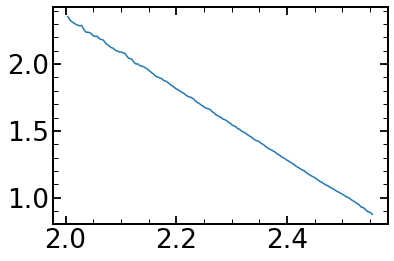

In [106]:
plt.plot(np.log10(np.array(distances_large[101:last_distance])),np.log10(res_diagonal_cross_large[101:last_distance]))

In [63]:
res=[]
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
res.append([i,z[0]])

In [64]:
res

[['/Users/nevencaplar/Documents/PFS/Testing/Final_Images/',
  -2.0386548969434815]]

## connection between real slope and deduced slope (add 0.05 to final result from modelled result)

In [114]:
run=8603
image_index=77

scidata_cut_large=np.load("/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_large.npy')
vardata_cut_large=np.load("/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_large.npy')


sci_image_large=scidata_cut_large
var_image_unit=vardata_cut_large

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

allparameters_proposal=np.array([0.1,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.67,0.1,0.0,0.0,0.07,-0.2,
                                 0.75,1.5,-0.2,0.00,
                                 0.1,-0.2,0.90,
                                 0.14,0.04,1.06,0.28,
                                 50000,2.7,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)

version of the code is: 0.14
-42964.9524676031


In [115]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

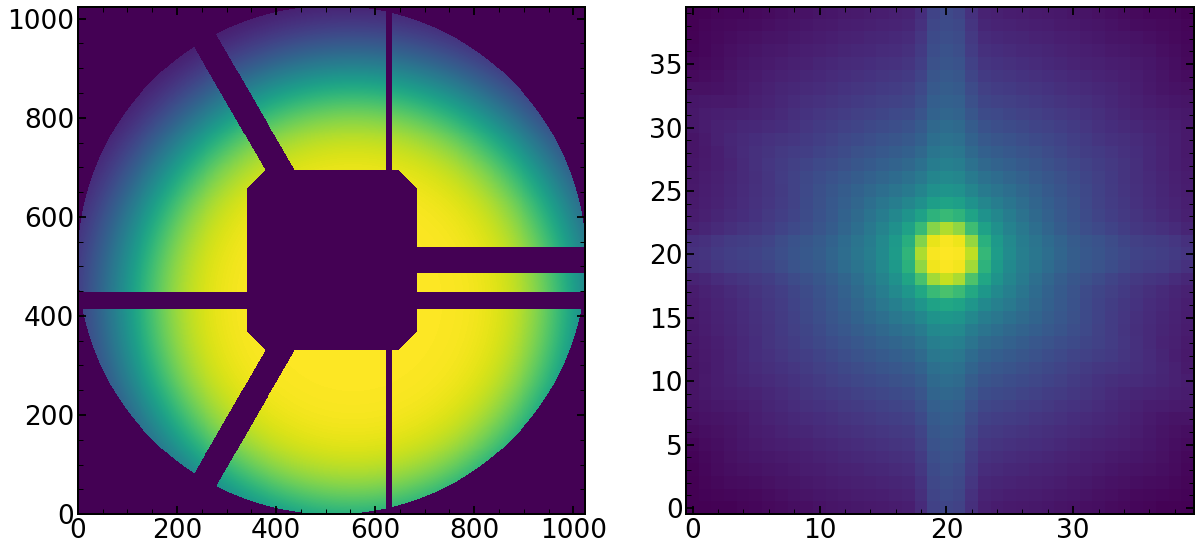

In [116]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

In [117]:
list_of_masks=create_mask(res_iapetus)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(res_iapetus,diagonal_cross,custom_cent=True,size_pixel=15)


res=[]
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
res.append([i,z[0]])
print(res)

[['/Users/nevencaplar/Documents/PFS/Testing/Final_Images/', -2.655747388937684]]


In [120]:
list_of_masks=create_mask(sci_image_large)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(res_iapetus,diagonal_cross,custom_cent=True,size_pixel=15)
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
deduced_scattering_slope=z[0]-0.05
deduced_scattering_slope

-2.705747388937684

In [123]:
pupil_parameters=None
parInit1=create_parInit(allparameters_proposal,None,pupil_parameters)
while len(parInit1)<400:
    parInit1_2=create_parInit(allparameters_proposal,None,pupil_parameters)
    parInit1=np.vstack((parInit1,parInit1_2))

248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248
248


In [127]:
columns[26]

'scattering_slope'

# Preparing a script

## Creating results_of_fit_many_interpolation_preDecemberrun

In [356]:
import pickle

with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalNe_expanded.pkl', 'rb') as f:
    finalNe=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalHgAr_expanded.pkl', 'rb') as f:
    finalHgAr=pickle.load(f)

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns_pre_extended=columns

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov132018/' + 'results_of_fit_many_interpolation_preNovember12run.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

columns_extended=np.concatenate((columns_pre_extended,['chi2', 'chi2max']),axis=0)
columns_extended_new=np.concatenate((columns,['chi2', 'chi2max']),axis=0)

for i in label:
    results_of_fit_many_interpolation[i]['radiometricEffect']=np.full(100,0.31)
    results_of_fit_many_interpolation[i]['radiometricExponent']=np.full(100,1.5)
    
# create an array
single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 


In [365]:

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns_analysis=columns+['chi2','chi2max']

results_of_fit_single=pd.DataFrame(np.zeros((len(finalHgAr.values[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=range(len(finalHgAr.values)),columns=columns_analysis)
results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_single)
results_of_fit_many_interpolation_preDecemberrun_HgAr = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                       '0p' :results_of_fit_many_single_defocus_pd.copy()}

results_of_fit_single=pd.DataFrame(np.zeros((len(finalNe.values[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=range(len(finalNe.values)),columns=columns_analysis)
results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_single)
results_of_fit_many_interpolation_preDecemberrun_Ne = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                       '0p' :results_of_fit_many_single_defocus_pd.copy()}


label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

In [366]:
for label_i in label:
    for i in range(120):
        results_of_fit_many_interpolation_preDecemberrun_HgAr[label_i].loc[i]=results_of_fit_many_interpolation[label_i].loc[finalHgAr.loc[i]['old_index_aprox']]

In [367]:
for label_i in label:
    for i in range(80):
        results_of_fit_many_interpolation_preDecemberrun_Ne[label_i].loc[i]=results_of_fit_many_interpolation[label_i].loc[finalNe.loc[i]['old_index_aprox']]

In [368]:
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/' + 'results_of_fit_many_interpolation_preDecemberrun_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_preDecemberrun_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)

In [526]:
results_of_fit_many_interpolation_preDecemberrun_Ne['m4'].loc[29]

z4                                  27.598658
z5                                  -0.190960
z6                                  -0.770967
z7                                   0.456247
z8                                   0.352211
z9                                  -0.242222
z10                                 -0.177209
z11                                 -0.709938
hscFrac                              0.692813
strutFrac                            0.094396
dxFocal                             -0.031847
dyFocal                              0.171686
slitFrac                             0.065812
slitFrac_dy                          0.122793
radiometricEffect                    0.310000
radiometricExponent                  1.500000
x_ilum                               0.042931
y_ilum                               0.060640
x_fiber                              0.000000
y_fiber                              0.000000
effective_radius_illumination        0.931763
frd_sigma                         

In [296]:
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/' + 'results_of_fit_many_interpolation_preDecemberrun_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_preDecemberrun_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

## Scripts

### Selection 

In [351]:
list_of_HgAr_to_analyze=finalHgAr.index[(finalHgAr['fiber'].values.astype(int)<=7)&(finalHgAr['fiber'].values.astype(int)>=2)&(finalHgAr['close'].values.astype(int)==1)]
print(len(list_of_HgAr_to_analyze))
list_of_Ne_to_analyze=finalNe.index[(finalNe['fiber'].values.astype(float)<=7)&(finalNe['fiber'].values.astype(float)>=2)&(finalNe['close'].values.astype(float)==1)]
print(len(list_of_Ne_to_analyze))

48
24


In [352]:
run=8552
sci_list=[]
for image_index in list_of_HgAr_to_analyze[14:24]:
    sci_list.append(np.load("/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy'))


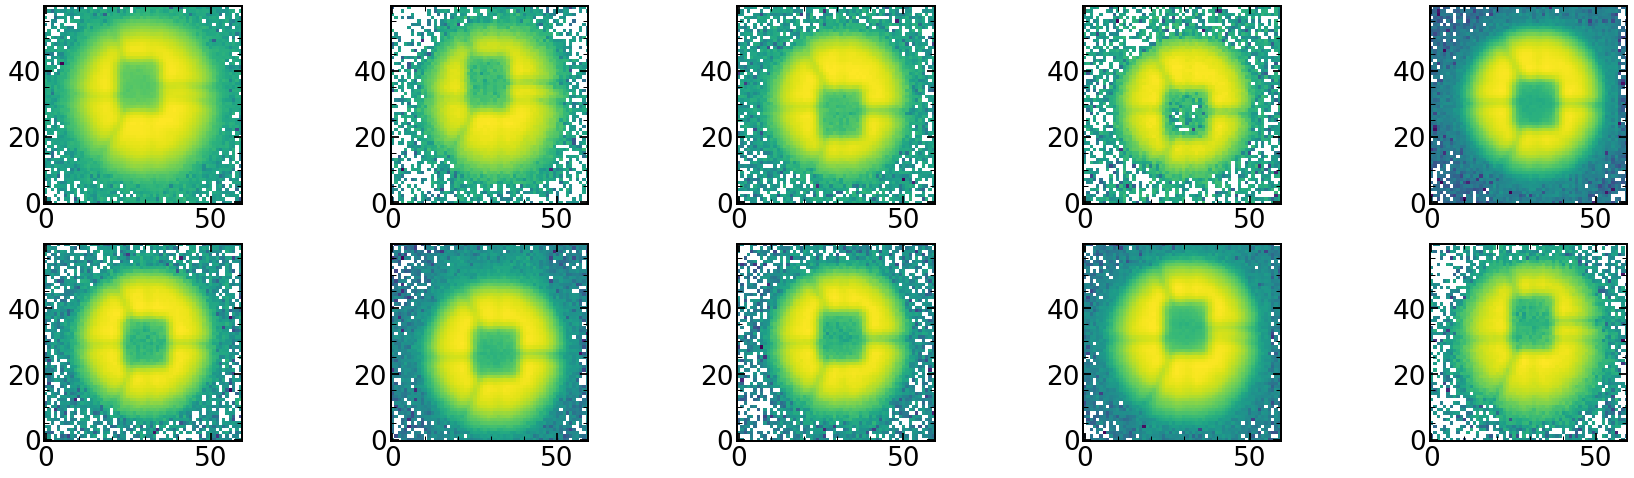

In [353]:
# to look if it looks ok
plt.figure(figsize=(30,8))
plt.subplot(251)
i=0
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(252)
i=1
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(253)
i=2
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(254)
i=3
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(255)
i=4
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(256)
i=5
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(257)
i=6
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(258)
i=7
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(259)
i=8
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())
plt.subplot(2,5,10)
i=9
plt.imshow(sci_list[i],origin='lower',norm=LogNorm())


### Script making

In [476]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Dec.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 18:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger1'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(single_spot)+'Dec.sh \n')

file.close()

In [477]:
#MPI
for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(2)+'S'+str(single_spot)+'Dec.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 18:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in np.array([8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558])+90:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI.py "+str(obs)+" "+str(single_spot)+" 40 5 Ne\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger2'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(2)+'S'+str(single_spot)+'Dec.sh \n')

file.close()

# Dec1 analysis

In [951]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns_pre_extended=columns

In [ ]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    for var_number in range(len(columns)):
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2 

In [ ]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']   

columns_analysis=columns+['chi2','chi2max']

columns_multi=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
                      'minorAxis','pupilAngle','effective_radius_illumination', 'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
                      'grating_lines','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  

In [ ]:
def create_results_of_fit_single(date,single_number):
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
            else:       
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [ ]:
def solution_at_0_and_plots(date,single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper):
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=3:
        solution_at_0=np.full(31,0)
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:
            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr_err)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]

            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            interim_zero_solutions=[]
            if q in columns[:8]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below removes 2 points from the fit that create largerst deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print(good_index)
                #print(index_arr_no0)
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            interim_zero_solutions=[]
            if q in columns[8:25]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[25:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######

            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

In [ ]:
for i in range(100):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Nov03',i)
    solution_at_0=solution_at_0_and_plots('Nov03',i,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)

## Look at the results at one point  - defocused analysis

In [937]:
date='Dec1'
obs='8627'
single_number='66'
image_index=int(single_number)
eps=5
arc='HgAr'

STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/"

if arc=="HgAr":
    single_number_focus=8603
elif arc=="Ne":
    single_number_focus=8693    
else:
    print("Not recognized arc-line")

if arc=='HgAr':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
elif arc=='Ne':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if arc=="HgAr":
    finalArc=finalHgAr
elif arc=="Ne":
    finalArc=finalNe    
else:
    print("Not recognized arc-line")    
        
finalArc.loc[int(single_number)]

fiber                     5
xc                     2088
yc                     1950
wavelength         795.0522
close                     1
lamp                   HgAr
xc_effective           2157
old_index                55
old_index_aprox          55
Name: 66, dtype: object

In [938]:
list_of_masks=create_mask(sci_image_focus_large)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(sci_image_focus_large,diagonal_cross,custom_cent=True,size_pixel=15)
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
# if the average is below 0 terminate at that position

where_are_NaNs=np.isnan(np.log10(np.array(res_diagonal_cross_large[101:])))
if np.sum(where_are_NaNs)>0:
    first_NaN_position=np.array(distances_large[101:])[where_are_NaNs][0]
else:
    first_NaN_position=last_distance
last_distance=np.min([first_NaN_position,last_distance]) -1

z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
deduced_scattering_slope=z[0]-0.05
print("deduced_scattering_slope: "+str(deduced_scattering_slope))

deduced_scattering_slope: -2.0909030783842426


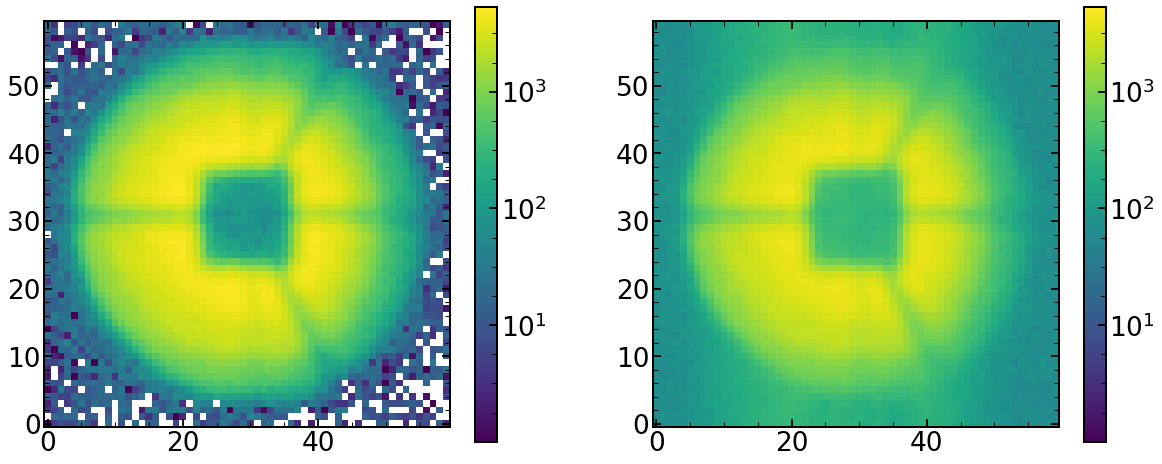

In [939]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


In [940]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 40, 31)
minimal likelihood is: 4233.7661100961
minimal chi2 reduced is: 2.3473864047336788


In [941]:
#minchain[22]=0.8
#minchain[18]=0.2
#minchain[19]=0.2
minchain
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4       z5        z6        z7        z8       z9       z10  \
0 -30.261903  0.08402  0.374857 -0.239367 -0.015037  0.18484 -0.264442   

       z11  
0 -0.64275  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.685454   0.076835  0.013897  0.008045  0.059099    -0.008232   

   radiometricEffect  radiometricExponent    x_ilum   y_ilum  
0           0.020999              0.08647  0.021588  0.23182  
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0  0.099631  0.038563                       0.865354    0.12455   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.098601  1.015828            -0.02507  115033.860191   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.090903              0.001395      0.505796  1.957814  0.988594  


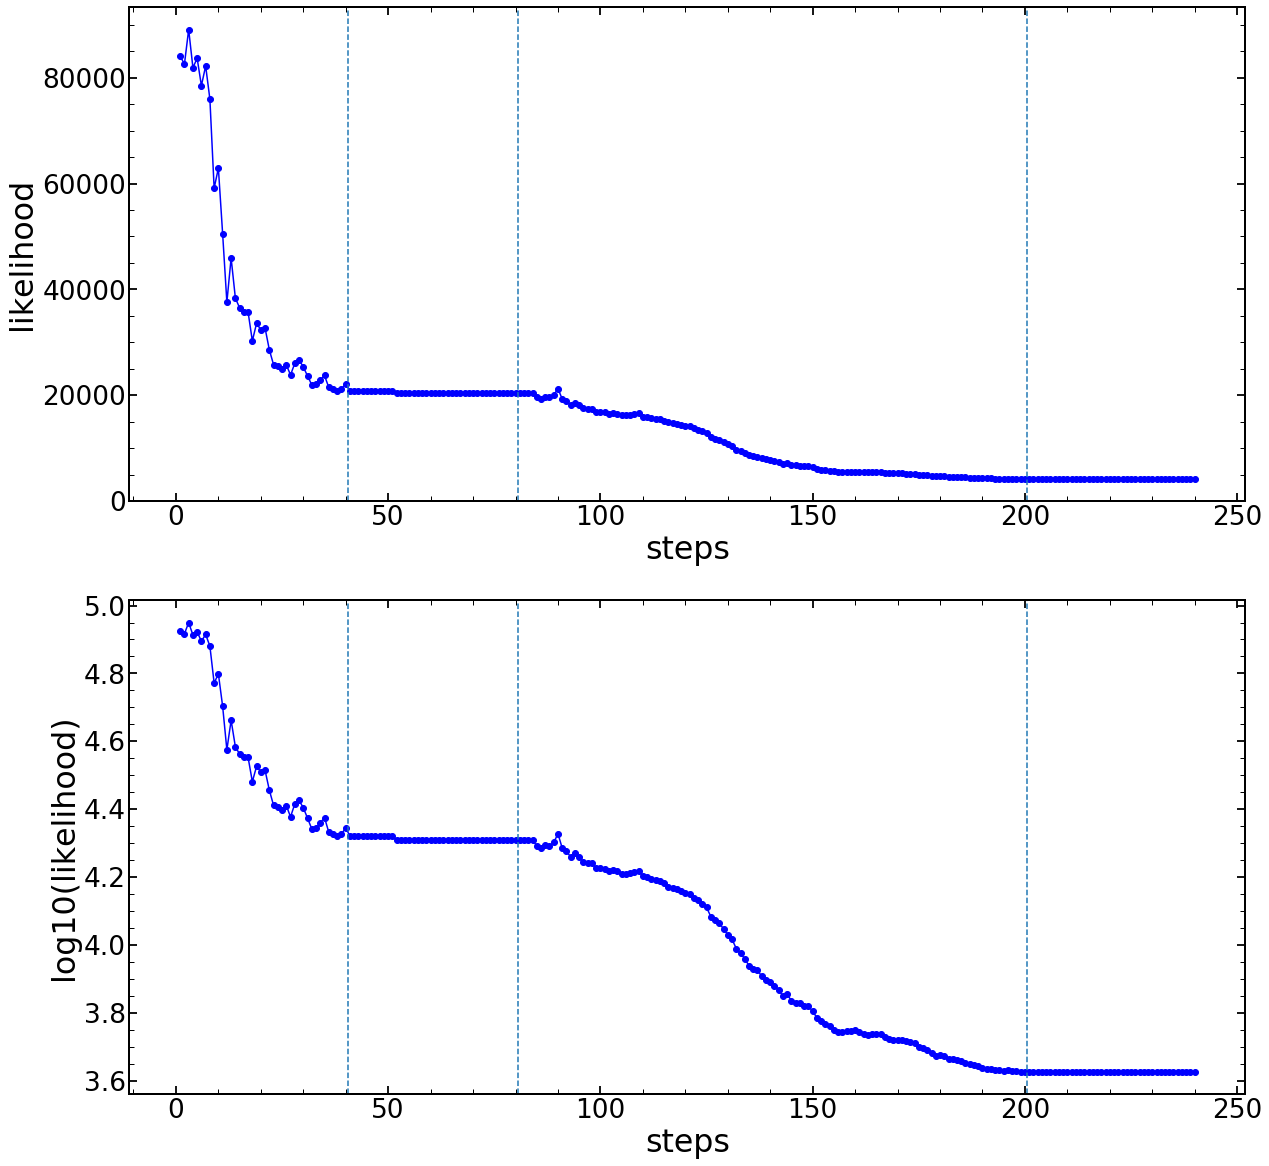

In [942]:
size=40

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [943]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
       
model(minchain)
#model(allparameters_proposal)

-9361.916037406674

In [944]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

#wf_grid_pure=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid_pure.npy') 
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')          

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

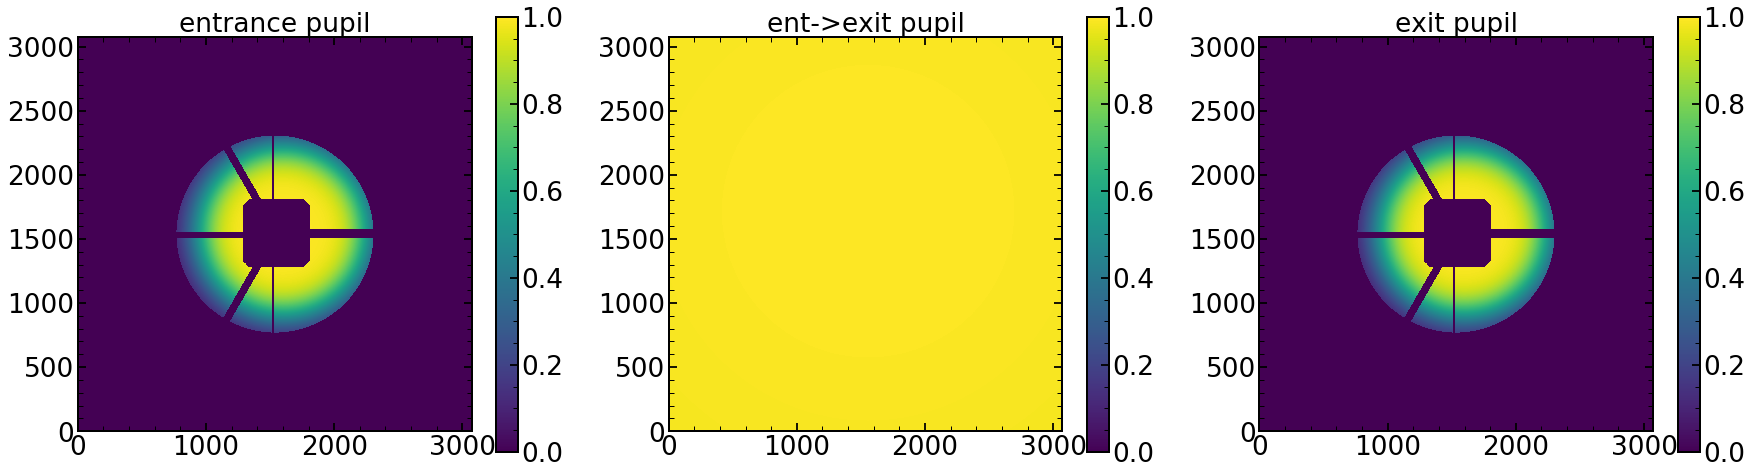

In [945]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

chi**2 reduced is: 5.196358599307128
Abs of residual divided by total flux is: 0.05272217050717617
Abs of residual divided by largest value of a flux in the image is: 0.0967182934849819


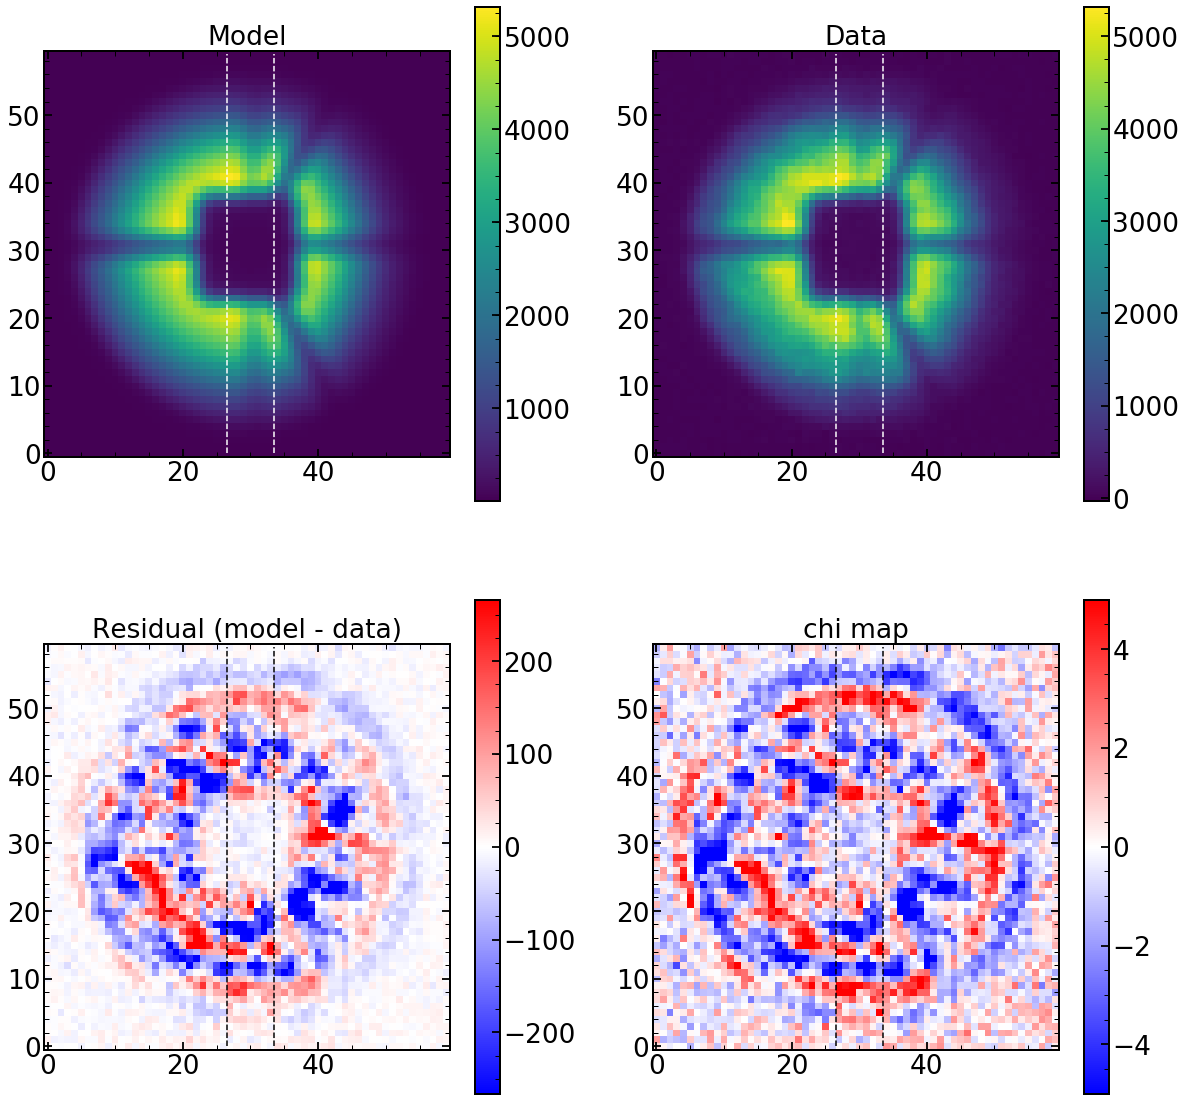

In [946]:
single_analysis.create_basic_comparison_plot()

5.196358599307128
chi**2 reduced is: 5.196358599307128
Abs of residual divided by total flux is: 0.05272217050717617
Abs of residual divided by largest value of a flux in the image is: 0.0967182934849819


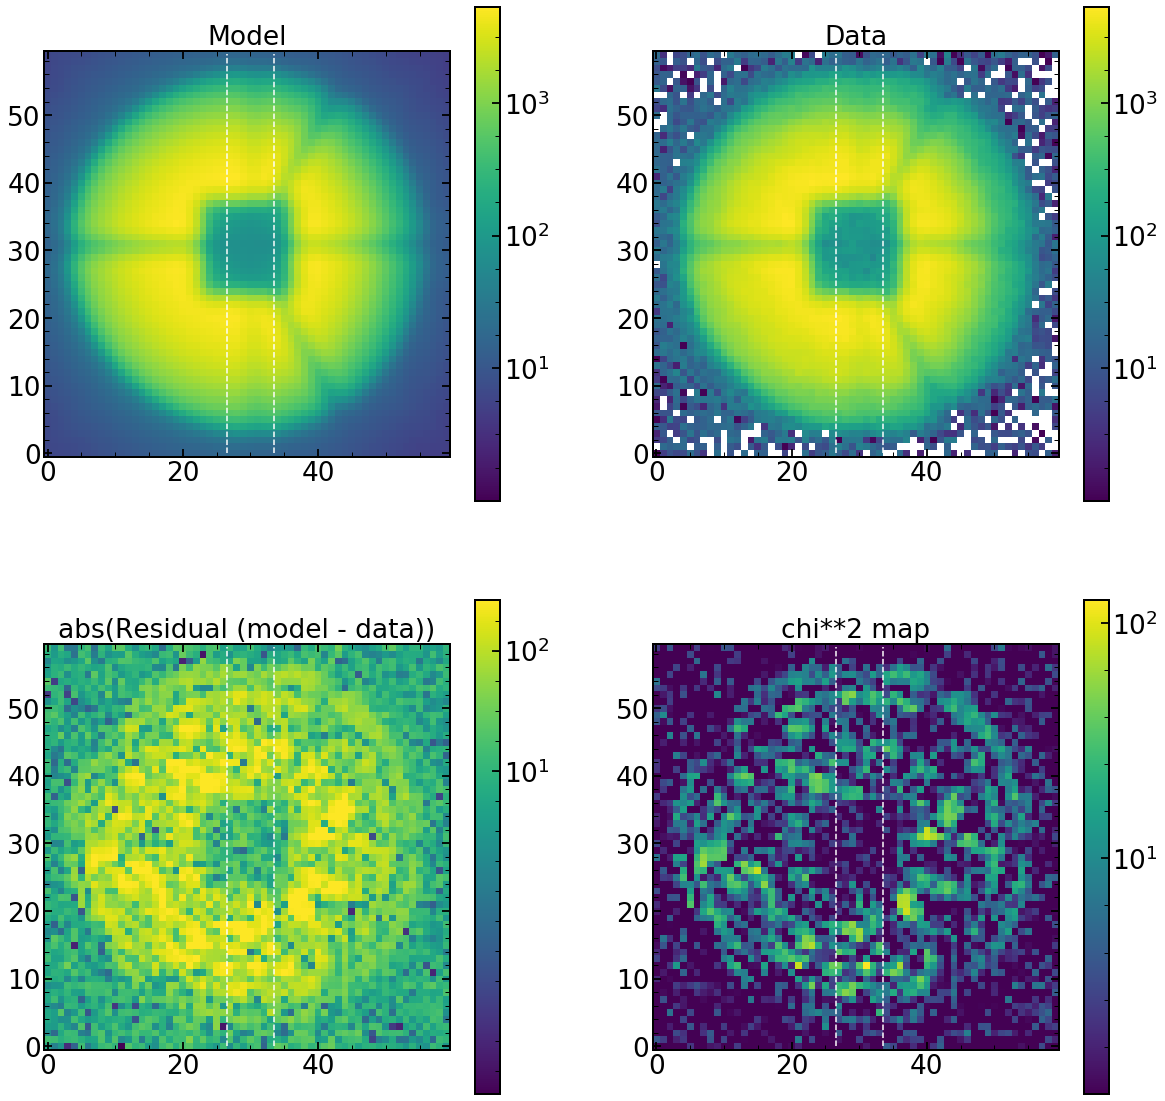

In [948]:
single_analysis.create_basic_comparison_plot_log()

5.196358599307128


0.05272217050717617

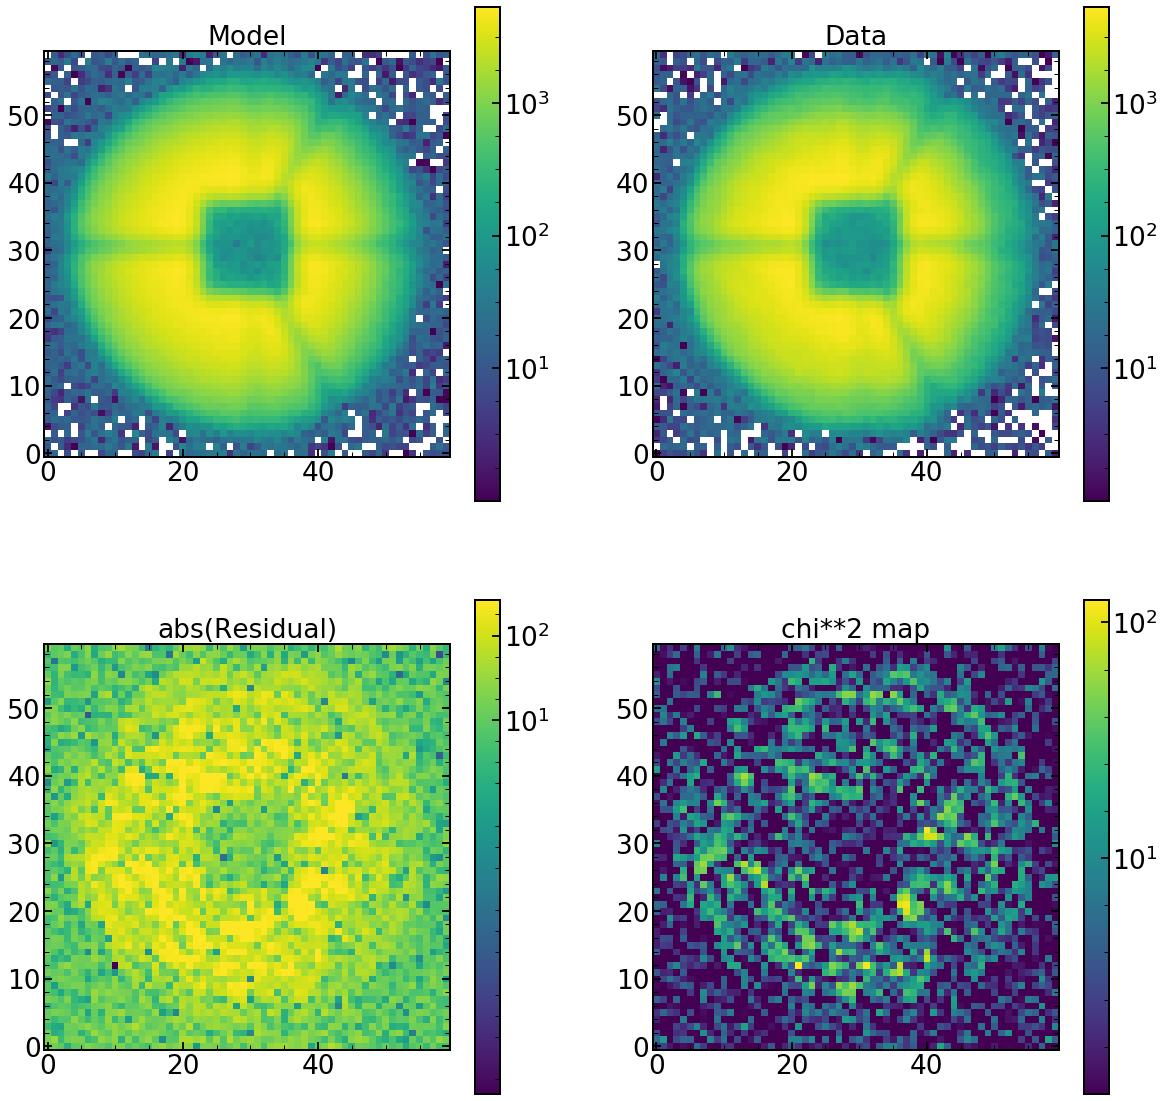

In [949]:
artifical_noise=single_analysis.create_artificial_noise()
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

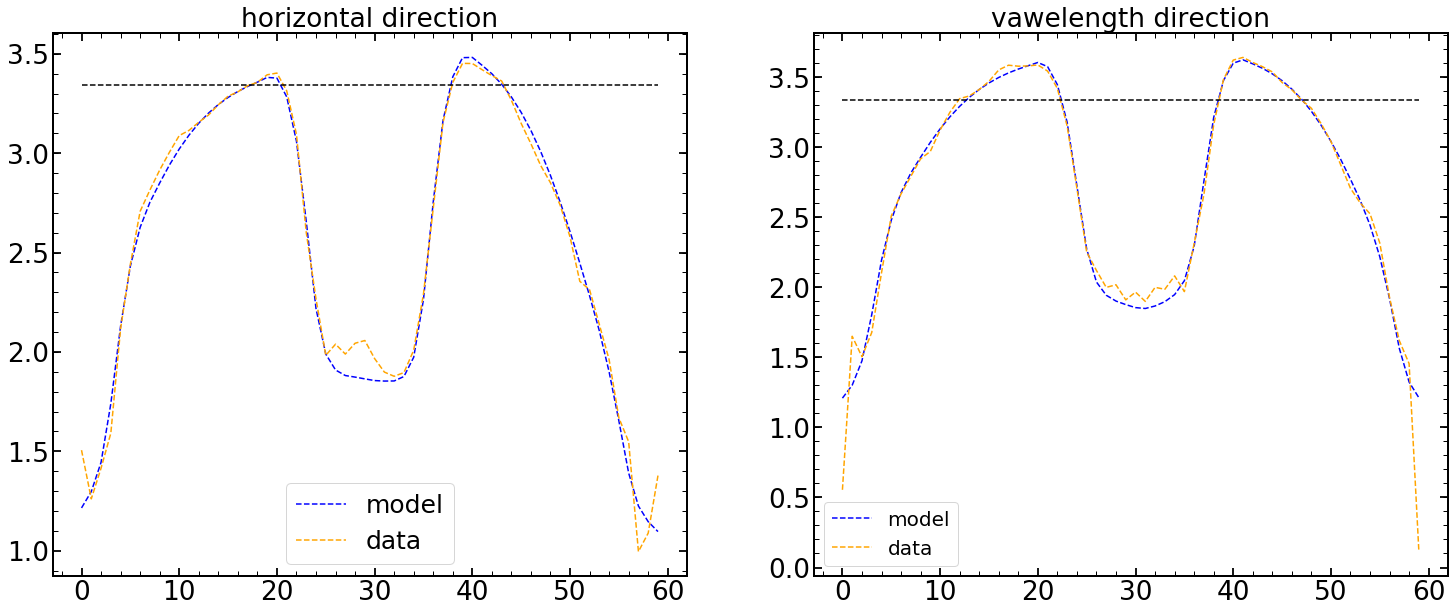

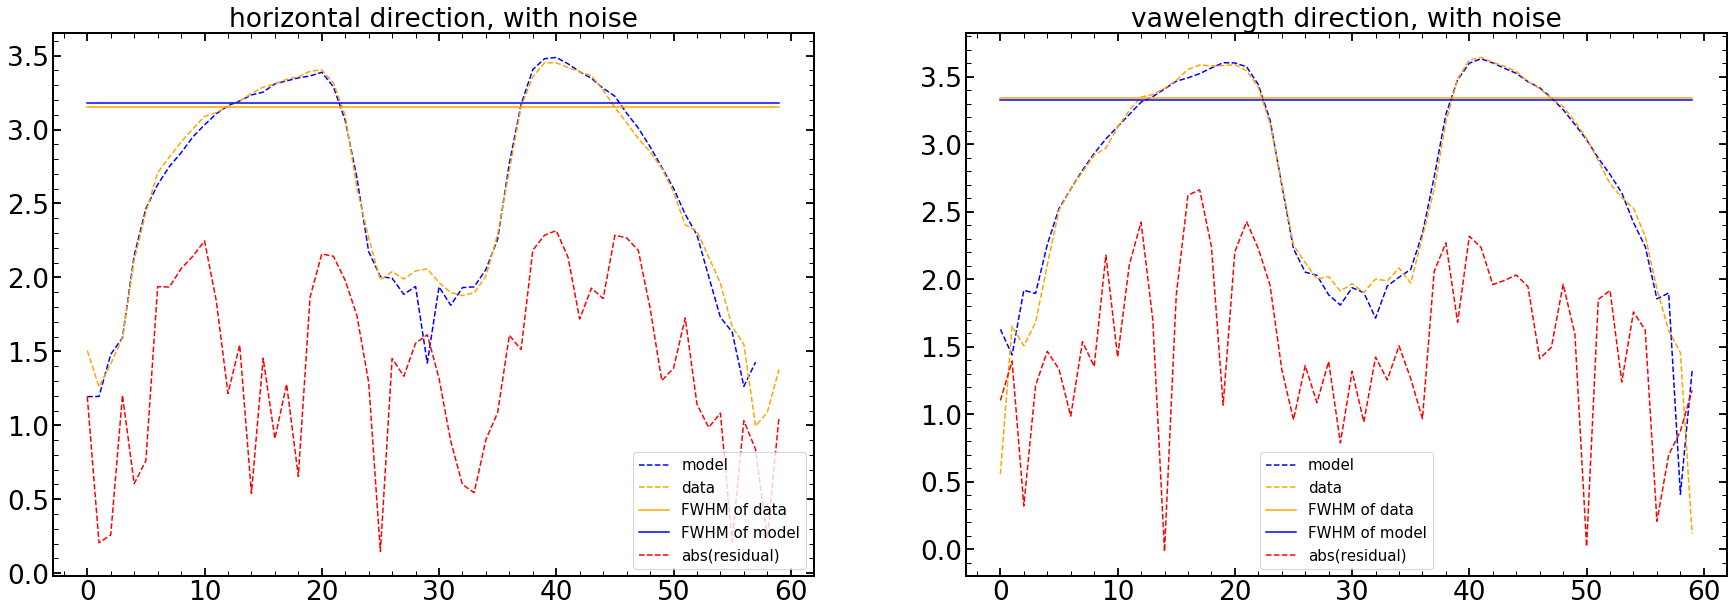

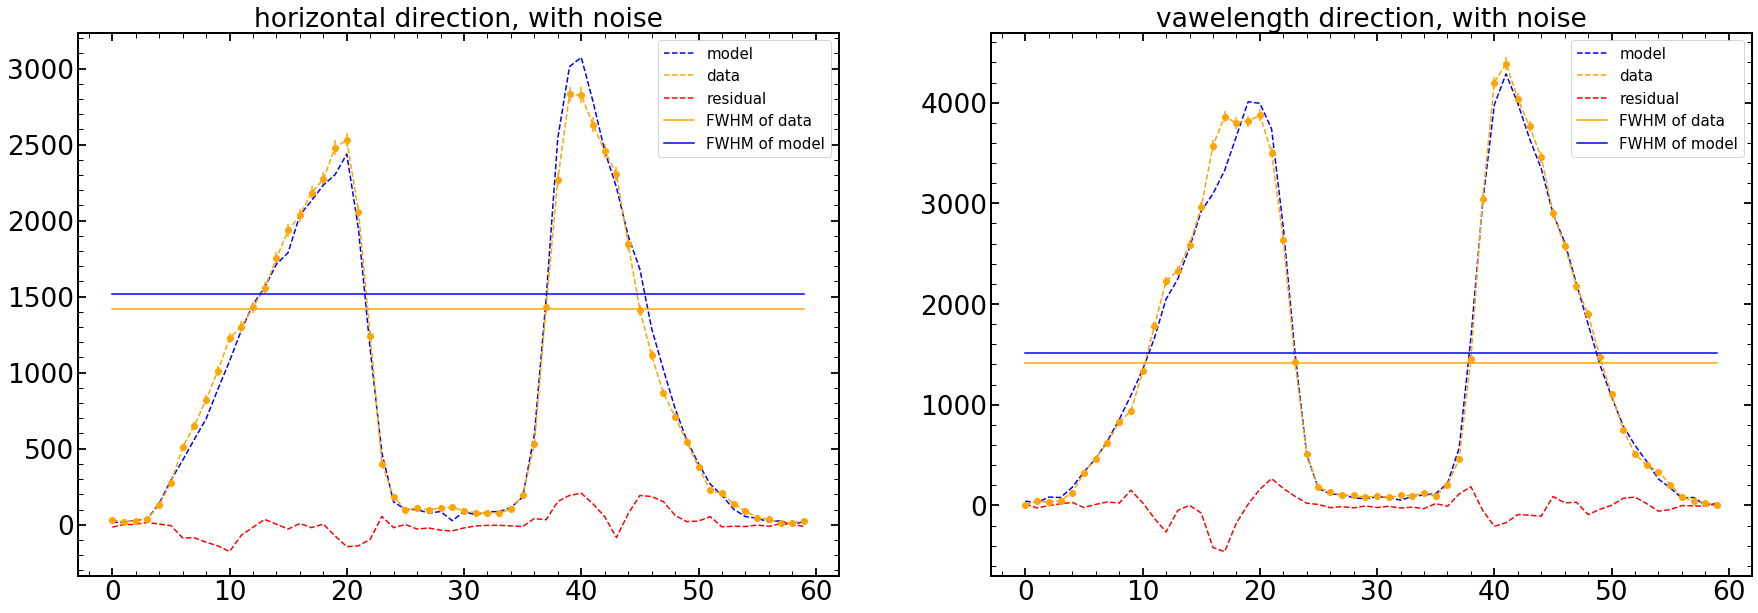

In [950]:
single_analysis.create_cut_plots()

In [649]:
finalNe

,fiber,xc,yc,wavelength,close,lamp,xc_effective,old_index,old_index_aprox
0,0.0,84,335,650.84186,0,Ne,84,NaN,90
1,0.0,84,365,653.4774,0,Ne,84,NaN,90
2,0.0,85,441,660.0668,1,Ne,85,NaN,90
3,0.0,86,533,668.01764,0,Ne,86,NaN,90
4,0.0,86,577,671.9268,0,Ne,86,NaN,90
5,0.0,88,821,693.13116,1,Ne,88,NaN,80
6,0.0,90,1102,717.59015,1,Ne,90,NaN,80
7,0.0,90,1184,724.72437,1,Ne,90,NaN,80
8,0.0,91,1407,744.1276,0,Ne,91,NaN,80
9,1.0,465,323,650.84186,0,Ne,465,NaN,91


In [759]:
parInit1=create_parInit(allparameters_proposal=allparameters_proposal,multi=None,pupil_parameters=None,allparameters_proposal_err=None,stronger=None,use_optPSF=None,deduced_scattering_slope=2.3)
parInit1[0]

array([   -0.57600245,    -0.5688324 ,    -0.36263996,     0.25277186,
           0.17585012,    -0.25192881,    -0.25680847,    -0.27142384,
           0.6803016 ,     0.09183651,    -0.06379403,     0.15696312,
           0.0626303 ,     0.10172961,     0.31      ,     1.5       ,
           0.04400065,     0.08715654,     0.        ,     0.        ,
           0.94116546,     0.01716515,     0.5       ,     1.0216307 ,
          -0.2256    , 75663.2128745 ,     2.3       ,     0.07781214,
           0.50243533,     1.87037243,     0.992758  ])